# Spanish Translation A/B Test

## Goal

A/B tests play a huge role in website optimization. Analyzing A/B tests data is a very important
data scientist responsibility. Especially, data scientists have to make sure that results are
reliable, trustworthy, and conclusions can be drawn.

Furthermore, companies often run tens, if not hundreds, of A/B tests at the same time. Manually
analyzing all of them would require lot of time and people. Therefore, it is common practice to
look at the typical A/B test analysis steps and try to automate as much as possible. This frees
up time for the data scientists to work on more high level topics.

## Challenge Description

This company is a worldwide e-commerce site with localized versions of the site.


It is noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. 

Spain and LatAm country manager suggested that one reason could be translation. All Spanishspeaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

1. Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

2. Explain why that might be happening. Are the localized translations really worse?

3. If identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

#libraries needed
require(dplyr)
require(rpart)
require(ggplot2)

In [2]:
install.packages('ggplot2', repos='http://cran.us.r-project.org')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [13]:
#read data
user = read.csv("user_table.csv")
test = read.csv("test_table.csv")

In [14]:
#let's create one data set
length(unique(test$user_id)) == length(test$user_id) # are there dupes?

[1] TRUE

In [15]:
length(unique(user$user_id)) == length(user$user_id) # are there dupes?

[1] TRUE

In [16]:
length(user$user_id) - length(test$user_id) # everyone in one table also in the other one?

[1] -454

In [17]:
data = merge(test,user, by = "user_id", all.x = TRUE) # this way we don't lose data
data$date = as.Date(data$date)
summary(data)

    user_id             date               source          device      
 Min.   :      1   Min.   :2015-11-30   Ads   :181877   Mobile:201756  
 1st Qu.: 249816   1st Qu.:2015-12-01   Direct: 90834   Web   :251565  
 Median : 500019   Median :2015-12-03   SEO   :180610                  
 Mean   : 499938   Mean   :2015-12-02                                  
 3rd Qu.: 749522   3rd Qu.:2015-12-04                                  
 Max.   :1000000   Max.   :2015-12-04                                  
                                                                       
 browser_language   ads_channel            browser         conversion     
 EN   : 63137     Bing    : 13689   Android_App:155135   Min.   :0.00000  
 ES   :377547     Facebook: 68425   Chrome     :101929   1st Qu.:0.00000  
 Other: 12637     Google  : 68180   FireFox    : 40766   Median :0.00000  
                  Other   :  4148   IE         : 61715   Mean   :0.04958  
                  Yahoo   : 27435   Iphone_App : 

First question is: check test results. But even before that, let’s make sure it is true Spain converts much
better than the rest of LatAm countries.

In [22]:
## we check the old version

data_conversion_country = data %>% group_by(country) %>% summarize( conversion = mean(conversion[test == 0]))%>% arrange (desc(conversion))

head(data_conversion_country)

,country,conversion
1,Spain,0.0797188212120042
2,NA,0.0775510204081633
3,El Salvador,0.053554040895813
4,Nicaragua,0.0526469727990641
5,Costa Rica,0.0522556390977444
6,Colombia,0.0520894861193148


Yes. Definitely true.

### In statistics, Welch's t-test, or unequal variances t-test, 

is a two-sample location test which is used to test the hypothesis that two populations have equal means. Welch's t-test is an adaptation of Student's t-test,[1] that is, it has been derived with the help of Student's t-test and is more reliable when the two samples have unequal variances and unequal sample sizes.[2] These tests are often referred to as "unpaired" or "independent samples" t-tests, as they are typically applied when the statistical units underlying the two samples being compared are non-overlapping. Given that Welch's t-test has been less popular than Student's t-test[2] and may be less familiar to readers, a more informative name is "Welch's unequal variances t-test" or "unequal variances t-test" for brevity.

### a simple t-test here should work. We have collected ~0.5MM data and test/control split is ~50/50.


In [23]:
data_test = subset(data, country != "Spain") #nothing changed in Spain, so no point in keeping those users
t.test(data_test$conversion[data_test$test == 1], data_test$conversion[data_test$test == 0])


	Welch Two Sample t-test

data:  data_test$conversion[data_test$test == 1] and data_test$conversion[data_test$test == 0]
t = -7.3539, df = 385260, p-value = 1.929e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.006181421 -0.003579837
sample estimates:
 mean of x  mean of y 
0.04341116 0.04829179 


https://onlinecourses.science.psu.edu/stat414/node/271

Not in the test are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop,
which would be dramatic if it were true. The most likely reason for weird A/B test results are:

#### We didn’t collect enough data.

#### Some bias has been introduced in the experiment so that test/control people are not really random.

In data science, whenever results appear too bad or too good to be true, they are not true.
Firstly, let’s plot day by day, to see if these weird results have been constantly happening or they just
started happening all of a sudden.

### Notes : Test vs. Control


A test group is one that receives an experimental treatment. This might include a survey incentive to promote response, a discount coupon to drive purchase behavior, or a retail store that receives additional training for its employees. In short these groups of customers, survey panelists, stores or markets are the focus of our manipulation of the independent variables.

What about the other guys?

Those groups that do not receive a treatment form the control. We use a control group because it allows us to make definitive statements about the impact of our manipulation. Imagine we are testing a direct mail promotion’s ability to impact sales or the addition of a new online customer chat feature’s ability to impact customer satisfaction. In either of these cases it is possible to see changes in the dependent variable (sales or customer satisfaction) which cannot be distinguished from our manipulation.

Use of a control group allows for isolating the percentage of customers who would have purchased regardless of the promotion. We expect the promotion to increase the percentage of customers who purchased and possibly impact their average spend. For the experiment to be deemed a success we must be able to compare it to the behavior of a group that did not receive the treatment.

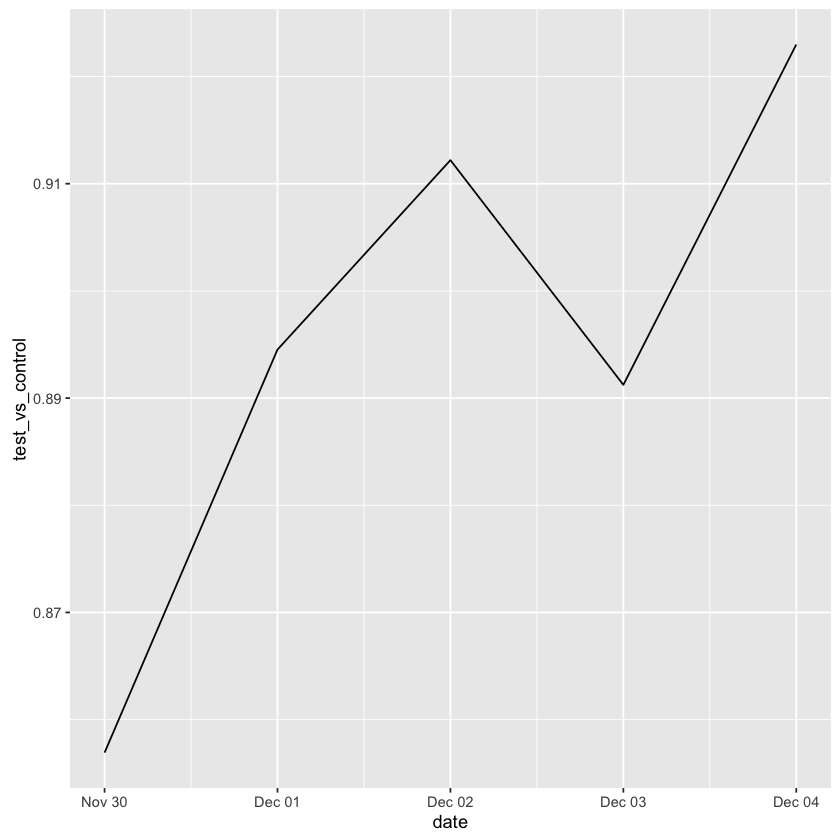

In [24]:
data_test_by_day = data_test %>%group_by(date) %>%summarize(test_vs_control = mean(conversion[test==1])/mean(conversion[test==0]))


qplot(date, test_vs_control, data= data_test_by_day, geom = "line")

From the plot, we notice a couple of things:

1. Test has constantly been worse than control and there is relatively little variance across days. That
probably means that we do have enough data, but there was some bias in the experiment set up.

2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to
capture weekly patterns, 2 weeks would be much better.
Time to find out the bias! Likely, there is for some reason some segment of users more likely to end up in
test or in control, this segment had a significantly above/below conversion rate and this affected the overall
results.
    
In an ideal world, the distribution of people in test and control for each segment should be the same.There
are many ways to check this. 
    
One way is to build a decision tree where the variables are the user dimensions and the outcome variable is whether the user is in test or control. If the tree splits, it means that for given values of that variable you are more likely to end up in test or control. 
    
But this should be impossible! Therefore, if the randomization worked, the tree should not split at all (or at least not be able to separate the two classes well).
Let’s check this:

https://rpubs.com/minma/cart_with_rpart

In [42]:
tree = rpart(test ~ .,data_test[,-8],control = rpart.control(minbucket = nrow(data_test)/100, maxdepth =2))
             
             # we only look for segments representing at least 1% of the populations.

tree # here we are not too interested in predictive power we are mainly using the tree as a descriptive stat tool.

n= 401085 

node), split, n, deviance, yval
      * denotes terminal node

1) root 401085 99692.820 0.5379757  
  2) country=Bolivia,Chile,Colombia,Costa Rica,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Nicaragua,Panama,Paraguay,Peru,Venezuela 350218 87553.970 0.4987693 *
  3) country=Argentina,Uruguay 50867  7894.097 0.8079108 *

Looks very interesting. The randomization is perfect for the countries on one side of the split
(country=Bolivia, Chile, Colombia, Costa Rica, Ecuador, EL Salvador, Guatemala, Honduras, Mexico,
Nicaragua, Panama, Paraguay, Peru, Venezuela). Indeed, in that leaf the test/control ratio is 0.498!
However, Argentina and Uruguay together have 80% test and 20% control! So let’s check the test results
after controlling for country. That is, we check for each country how the test is doing:

In [41]:
data_test_country = data_test %>%group_by(country) %>%summarize( p_value = t.test( conversion[test==1],conversion[test==0])$p.value,conversion_test = t.test( conversion[test==1],conversion[test==0])$estimate[1],conversion_control = t.test( conversion[test==1],conversion[test==0])$estimate[2]) %>%arrange (p_value)

data_test_country
83

,country,p_value,conversion_test,conversion_control
1,Mexico,0.165543722110397,0.0511863088292493,0.0494946191343893
2,El Salvador,0.248126674326668,0.0479468895992132,0.053554040895813
3,Chile,0.302847643084447,0.0512950222581951,0.0481071754795494
4,Argentina,0.335146546874686,0.0137250180592343,0.0150705429670799
5,Colombia,0.423719074131412,0.0505709624796085,0.0520894861193148
6,Honduras,0.471462856525758,0.0475398145947231,0.0509057555606512
7,Guatemala,0.572107208191207,0.0486472077835532,0.0506428758855943
8,Venezuela,0.573701523438725,0.0489783087079535,0.0503436745309307
9,Costa Rica,0.687876353707399,0.0547376368440921,0.0522556390977444
10,Panama,0.705326837272589,0.0493702770780856,0.046795523906409


[1] 83

### Conclusion : After we control for country, the test clearly appears non significant. Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!